In [18]:
import dotenv
dotenv.load_dotenv()

import sys, os
dir_head = os.environ.get("REPO_DIR", ".")
sys.path.insert(0, os.path.join(dir_head, "src"))

import numpy as np
from pixell import enmap

import warnings
import itertools

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
import utils as ut
import covariance as cov
import matplotlib.pyplot as plt

In [19]:
# setup
# latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# font size
plt.rcParams.update({'font.size': 20})

config_data_fname = "/home/gill/research/ACT/multi-freq-bridge/configs/case46_ajay.yaml"
config_data = ut.get_config_file(config_data_fname)

cluster_region = ut.get_region(region_center_ra=config_data['region_center_ra'], 
                               region_center_dec=config_data['region_center_dec'],
                               region_width=config_data['region_width'])

fname = "/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits"

plot_1d = 1
plot_2d = 1

data_ref = ut.imap_dim_check(enmap.read_map(fname=fname, box=cluster_region))
data_shape, data_wcs = data_ref.shape, data_ref.wcs
geometry = (data_shape, data_wcs)

Calculating for: ('217_npipe_planck_sky', '217_npipe_planck_sky')
Smoothing tpsd: 1.25 pix.


<Figure size 800x600 with 0 Axes>

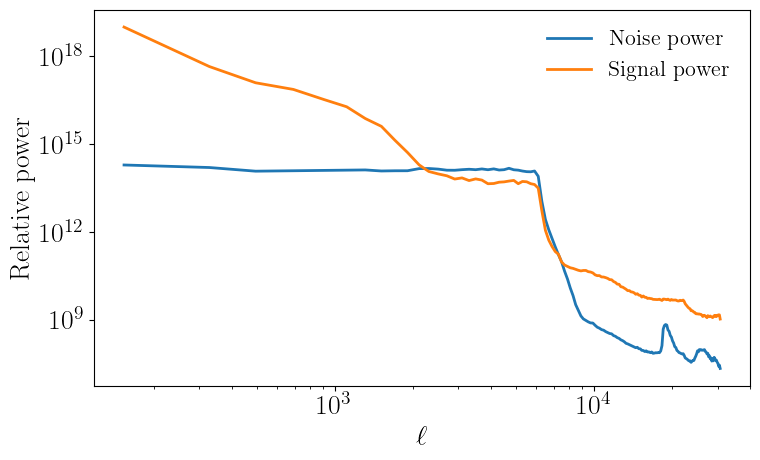

In [23]:
# Calculate covariances
combos = list(itertools.product(config_data['data'], config_data['data']))
binsize = 200

# flags
plot_1d = 0
plot_2d = 0
plot_regions = 1
plot_2d_rad_ave = 0
whiten_planck = 1
whiten_act = 1

data_shape, data_wcs = geometry
debug_pix_noise = (False, False)

ACT_DATA_DIR = "/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj/"
PLANCK_DATA_DIR = "/home/gill/research/ACT/bridge/data_paper/data/data/planck_no_reproj/"

for combo in combos:
    freq1 = combo[0].split('_')[0]
    array1 = combo[0].split('_')[1]
    inst1 = combo[0].split('_')[2]
    scan1 = combo[0].split('_')[3]

    freq2 = combo[1].split('_')[0]
    array2 = combo[1].split('_')[1]
    inst2 = combo[1].split('_')[2]
    scan2 = combo[1].split('_')[3]

    if combo[0] != combo[1]: continue

    if inst1 == 'act':
        data_dir1 = ACT_DATA_DIR
    elif inst1 == 'planck':
        data_dir1 = PLANCK_DATA_DIR

    if inst2 == 'act':
        data_dir2 = ACT_DATA_DIR
    elif inst2 == 'planck':
        data_dir2 = PLANCK_DATA_DIR

    print("Calculating for: {}".format(combo))

    mean_tpsd, mean_npsd, mean_spsd, all_regions_npsd, all_regions_spsd = cov.get_covariance(freq1=freq1, 
                                                                                             freq2=freq2,
                                            
                                                                                             array1=array1, 
                                                                                             array2=array2,
                                                         
                                                                                             inst1=inst1, 
                                                                                             inst2=inst2,
                                                         
                                                                                             data_dir1=data_dir1,
                                                                                             data_dir2=data_dir2,
                                                                                             
                                                                                             data_wcs=geometry[1],
                                                                                             
                                                                                             cf=config_data,
                                                                                             debug_pix_noise=debug_pix_noise,)
                
    
    # mean_tpsd_real = np.fft.ifft2(mean_tpsd)
    # mean_tpsd_real = enmap.enmap(mean_tpsd_real, geometry[1])

    # ut.plot_image(np.fft.fftshift(np.abs(mean_tpsd_real)), interval_type="zscale", title="Mean noise power spectrum (real space)", 
    #               modlmap=mean_tpsd.modlmap())
    
    # ut.plot_image(np.fft.fftshift(abs(mean_tpsd)), interval_type="zscale", title="Mean noise power spectrum (Fourier space)",
    #               modlmap=mean_tpsd.modlmap())
    
    # cluster_tpsd = np.abs(mean_spsd) + np.abs(all_regions_npsd[-1])

    # all_regions_tpsd = [np.abs(mean_spsd) + np.abs(region) for region in all_regions_spsd]
    plt.figure(figsize=(8, 6))

    mean_all_regions_npsd = np.mean(np.abs(all_regions_npsd[:-1]), axis=0)
    mean_all_regions_npsd = enmap.enmap(mean_all_regions_npsd, geometry[1])
    mean_all_regions_spsd = np.mean(np.abs(all_regions_spsd[:-1]), axis=0)
    mean_all_regions_spsd = enmap.enmap(mean_all_regions_spsd, geometry[1])

    if inst1 == 'act':
        npsd_list = [mean_all_regions_npsd, np.abs(all_regions_npsd[-1])]
        spsd_list = [mean_spsd]
    else:
        npsd_list = [mean_npsd]
        spsd_list = [mean_spsd]

    plt.figure(figsize=(8, 5))
    for i, npsd in enumerate(npsd_list):
        b_npsd, l_npsd = enmap.lbin(map=np.abs(npsd), bsize=binsize)
        # Normalize so the maximum value equals 1
        b_npsd_norm = b_npsd 
        color = "C0"
        if i == 0:
            plt.loglog(l_npsd, b_npsd_norm, label="Noise power", lw=2, color=color)
        else:
            plt.loglog(l_npsd, b_npsd_norm, label="Noise power (cluster pair region)", lw=2, linestyle="--", color=color)

    for i, spsd in enumerate(spsd_list):
        b_spsd, l_spsd = enmap.lbin(map=np.abs(spsd), bsize=binsize)
        # Normalize so the maximum value equals 1
        b_spsd_norm = b_spsd 
        color = "C1"
        if i == 0:
            plt.loglog(l_spsd, b_spsd_norm, label="Signal power", lw=2, color=color)
        else:
            plt.loglog(l_spsd, b_spsd_norm, label="Signal Cluster", lw=2, linestyle="--", color=color)

    plt.xlabel(r"$\ell$")
    plt.legend(fontsize=16, frameon=False)
    plt.ylabel("Relative power")
    plt.tight_layout()
    plt.savefig(f"../plots/psd_{combo[0]}_{combo[1]}.eps", format="eps", dpi=300)
    plt.show()
    
    # # Plot noise power spectra (using all_regions_npsd)
    # plt.subplot(1, 1, 1)
    # for i, region in enumerate(all_regions_npsd):
    #     b_region, l_region = enmap.lbin(map=np.abs(region), bsize=binsize)
    #     if i == 8:
    #         plt.loglog(l_region, b_region, label="Cluster pair (noise)", lw=2)
    #     else:
    #         plt.loglog(l_region, b_region, label=f"Region {i} (noise)", alpha=0.5)

    # # Plot signal power spectra (using all_regions_spsd)
    # for i, region in enumerate(all_regions_spsd):
    #     b_region, l_region = enmap.lbin(map=np.abs(region), bsize=binsize)
    #     if i == 8:
    #         plt.loglog(l_region, b_region, label="Cluster pair (signal)", lw=2)
    #     else:
    #         plt.loglog(l_region, b_region, label=f"Region {i} (signal)", alpha=0.7)
    
    # plt.xlabel(r"$\ell$", fontsize=14)
    # plt.title("Signal Spectrum", fontsize=16)
    # plt.legend(fontsize=10)
    
    # plt.tight_layout()
    # plt.show()

    # if plot_regions:
    #     for i, region in enumerate(all_regions_npsd):
    #         label = f"Region {i}"
    #         if i == 8: label = "Cluster"
    #         ut.plot_image(np.fft.fftshift(np.abs(all_regions_npsd[i])), 
    #                       interval_type="zscale", title=label)
    
    # Radial average
    # b_cluster, l_cluster = enmap.lbin(map=cluster_tpsd, bsize=binsize)
    # tpsd_fit_2d = cov.fit_one_over_f(l_npsd=l_cluster, b_npsd=b_cluster,
    #                                  mask_value=250, geometry=geometry)
    
    # if plot_2d_rad_ave:
    #     ut.plot_image(np.fft.fftshift(tpsd_fit_2d), interval_type="zscale", 
    #                   title="Cluster region noise power spectrum radial average")
        

    # if plot_1d:
    #     b_cluster, l_cluster = enmap.lbin(map=cluster_tpsd, bsize=binsize)
    #     b_tpsd, l_tpsd = enmap.lbin(map=np.abs(mean_tpsd), bsize=binsize)

    #     plt.figure(figsize=(7, 5))
    #     plt.loglog(l_cluster, b_cluster, label="Cluster")
    #     #plt.loglog(l_tpsd, b_tpsd, label="Averaging")
    #     # plt.loglog(l_ave, b_ave, label="Radial averaging")
    #     plt.title(f"Combo: {combo}: Absolute value of the power spectrum", fontsize=10)
    #     plt.legend(fontsize=8)
    #     plt.grid()
    #     plt.show()

    # if plot_2d:
    #     ut.plot_image(np.fft.fftshift(np.abs(all_regions_npsd[-1])), 
    #                   interval_type="zscale", title="Cluster region noise power spectrum")
    #     # plot average noise power spectrum
    #     ut.plot_image(np.fft.fftshift(np.abs(mean_npsd)), 
    #                   interval_type="zscale", title="Average noise power spectrum")

In [4]:
b_masked_2d

NameError: name 'b_masked_2d' is not defined